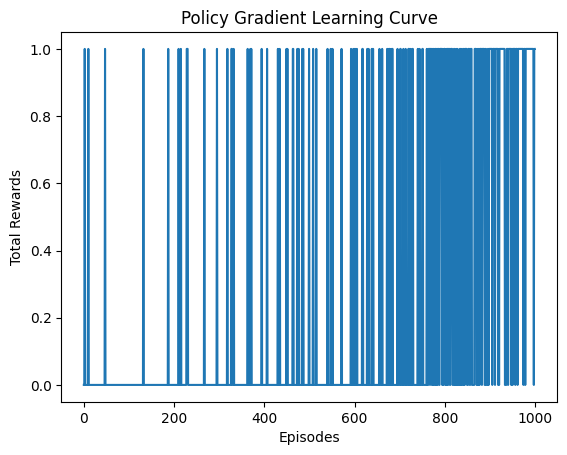

In [6]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.01, gamma=0.99):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions  # Initialize policy
    
    def select_action(self, state):
        prob = self.policy[state]
        prob = np.maximum(prob, 0)  # Ensure non-negative values
        prob /= np.sum(prob)  # Normalize
        return np.random.choice(self.num_actions, p=prob)
    
    def update_policy(self, trajectory):
        for state, action, G in trajectory:
            self.policy[state, action] += self.learning_rate * G
        
        # Ensure probabilities remain valid
        self.policy = np.maximum(self.policy, 0)  # Remove negatives
        self.policy /= np.sum(self.policy, axis=1, keepdims=True)  # Normalize per state
    
    def train(self, num_episodes, custom_reward=None):
        rewards_per_episode = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            trajectory = []
            total_reward = 0
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                
                if custom_reward:
                    reward = custom_reward(state, action, reward, next_state)
                
                trajectory.append((state, action, reward))
                state = next_state
                total_reward += reward
            
            rewards_per_episode.append(total_reward)
            
            # Compute returns and update policy
            G = 0
            discounted_trajectory = []
            for state, action, reward in reversed(trajectory):
                G = reward + self.gamma * G
                discounted_trajectory.insert(0, (state, action, G))
            
            self.update_policy(discounted_trajectory)
        
        return rewards_per_episode

# Create environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# Train Policy Gradient Agent
pg_agent = PolicyGradientAgent(env)
rewards_pg = pg_agent.train(1000)

# Plot Learning Curves
plt.plot(rewards_pg)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.title("Policy Gradient Learning Curve")
plt.show()


Episode 0: Total Reward: -9.0
Episode 100: Total Reward: -8.5
Episode 200: Total Reward: -9.0
Episode 300: Total Reward: -9.0
Episode 400: Total Reward: -9.0
Episode 500: Total Reward: -9.0
Episode 600: Total Reward: -9.0
Episode 700: Total Reward: -9.0
Episode 800: Total Reward: -9.0
Episode 900: Total Reward: -9.0


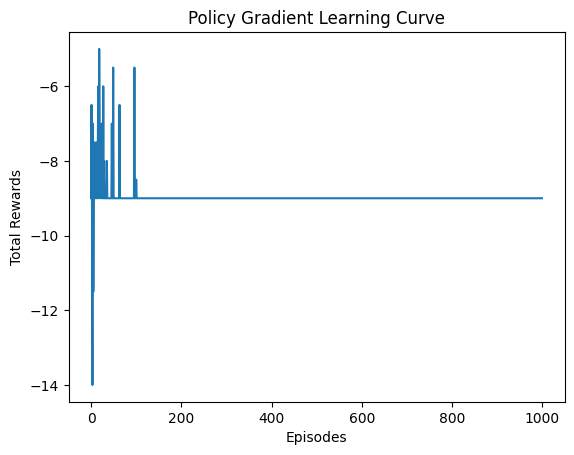

In [7]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.01, gamma=0.99):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions
    
    def select_action(self, state):
        prob = np.maximum(self.policy[state], 0)  # Ensure non-negative probabilities
        prob /= np.sum(prob)  # Normalize to sum to 1
        return np.random.choice(self.num_actions, p=prob)
    
    def update_policy(self, trajectory):
        G = 0
        for state, action, reward in reversed(trajectory):
            G = reward + self.gamma * G
            self.policy[state] *= 0.99  # Decay old probabilities
            self.policy[state, action] += self.learning_rate * G
        self.policy = np.maximum(self.policy, 0)  # Avoid negative values
        self.policy /= np.sum(self.policy, axis=1, keepdims=True)  # Normalize
    
    def custom_reward(self, state, next_state, done):
        goal_state = self.env.observation_space.n - 1
        hole_penalty = -10
        move_penalty = -0.5
        move_reward = 1.0
        
        if done:
            return 10 if next_state == goal_state else hole_penalty
        
        current_dist = abs(state - goal_state)
        new_dist = abs(next_state - goal_state)
        
        return move_reward if new_dist < current_dist else move_penalty
    
    def train(self, num_episodes):
        rewards_per_episode = []
        
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            trajectory = []
            total_reward = 0
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                reward = self.custom_reward(state, next_state, done)
                trajectory.append((state, action, reward))
                total_reward += reward
                state = next_state
            
            self.update_policy(trajectory)
            rewards_per_episode.append(total_reward)
            
            if episode % 100 == 0:
                print(f"Episode {episode}: Total Reward: {total_reward}")
                
        return rewards_per_episode

# Initialize Environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# Train Policy Gradient Agent
pg_agent = PolicyGradientAgent(env)
rewards_pg = pg_agent.train(1000)

# Plot Learning Curves
plt.plot(rewards_pg)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.title("Policy Gradient Learning Curve")
plt.show()

In [14]:
import numpy as np
import gym
import random

# Q-learning Parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.99  # Discount factor
EPSILON = 0.1  # Exploration rate
EPISODES = 500  # Reduced number of episodes for faster convergence
MAX_STEPS = 100  # Max steps per episode

# Environment Setup
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8")

# Initialize Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Custom Reward Function
def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    # If the agent reaches the goal
    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    # Otherwise, provide a reward based on proximity to the goal (Manhattan distance)
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

# Q-learning Agent
def train_q_learning(env, q_table, episodes, max_steps, alpha, gamma, epsilon):
    for episode in range(episodes):
        state = env.reset()  # Start a new episode (updated for gym version)
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Exploration vs Exploitation
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(q_table[state])  # Exploit: best action from Q-table

            # Take action, observe reward and new state
            next_state, reward, done, info = env.step(action)  # Fixed unpacking to 4 values

            reward = custom_reward(state, action, next_state, done)  # Use custom reward

            # Update Q-table using the Q-learning formula
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            total_reward += reward
            state = next_state  # Transition to the next state

            if done:
                break

        # Every 100 episodes, print the progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")

# Train the Q-learning agent
train_q_learning(env, q_table, EPISODES, MAX_STEPS, ALPHA, GAMMA, EPSILON)

# Test the agent
def test_agent(env, q_table):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = np.argmax(q_table[state])  # Best action from Q-table
        next_state, reward, done, info = env.step(action)
        total_reward += custom_reward(state, action, next_state, done)  # Use custom reward
        state = next_state
        steps += 1
        if steps > MAX_STEPS:
            break

    print(f"Test: Total Reward: {total_reward}")

# Test the trained agent
test_agent(env, q_table)

# Visualization of the learned policy
def visualize_policy(q_table):
    policy = np.argmax(q_table, axis=1).reshape(8, 8)
    print("Learned Policy:")
    print(policy)

visualize_policy(q_table)


Episode 100/500, Total Reward: -157.1
Episode 200/500, Total Reward: -167.3
Episode 300/500, Total Reward: -209.7
Episode 400/500, Total Reward: -172.39999999999998
Episode 500/500, Total Reward: -146.29999999999993
Test: Total Reward: -114.79999999999995
Learned Policy:
[[2 3 2 3 2 2 1 2]
 [1 0 2 1 2 2 2 2]
 [1 0 3 0 3 3 1 0]
 [1 1 0 3 0 0 2 2]
 [1 3 0 0 2 2 3 2]
 [0 0 0 2 3 0 0 2]
 [0 0 1 0 0 2 0 2]
 [1 1 0 0 1 1 2 0]]


In [15]:
import numpy as np
import gym
import random

# Q-learning Parameters
ALPHA = 0.2  # Learning rate (optimal value for stable learning)
GAMMA = 0.95  # Discount factor (balance between short-term and long-term rewards)
EPSILON = 0.1  # Exploration rate (exploration vs exploitation tradeoff)
EPISODES = 500  # Reduced number of episodes for faster convergence
MAX_STEPS = 100  # Max steps per episode

# Environment Setup
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8")

# Initialize Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Custom Reward Function
def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    # If the agent reaches the goal
    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    # Otherwise, provide a reward based on proximity to the goal (Manhattan distance)
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

# Q-learning Agent
def train_q_learning(env, q_table, episodes, max_steps, alpha, gamma, epsilon):
    for episode in range(episodes):
        state = env.reset()  # Start a new episode (updated for gym version)
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Exploration vs Exploitation
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(q_table[state])  # Exploit: best action from Q-table

            # Take action, observe reward and new state
            next_state, reward, done, info = env.step(action)  # Fixed unpacking to 4 values

            reward = custom_reward(state, action, next_state, done)  # Use custom reward

            # Update Q-table using the Q-learning formula
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            total_reward += reward
            state = next_state  # Transition to the next state

            if done:
                break

        # Every 100 episodes, print the progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")

# Train the Q-learning agent
train_q_learning(env, q_table, EPISODES, MAX_STEPS, ALPHA, GAMMA, EPSILON)

# Test the agent
def test_agent(env, q_table):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = np.argmax(q_table[state])  # Best action from Q-table
        next_state, reward, done, info = env.step(action)
        total_reward += custom_reward(state, action, next_state, done)  # Use custom reward
        state = next_state
        steps += 1
        if steps > MAX_STEPS:
            break

    print(f"Test: Total Reward: {total_reward}")

# Test the trained agent
test_agent(env, q_table)

# Visualization of the learned policy
def visualize_policy(q_table):
    policy = np.argmax(q_table, axis=1).reshape(8, 8)
    print("Learned Policy:")
    print(policy)

visualize_policy(q_table)


Episode 100/500, Total Reward: -478.5
Episode 200/500, Total Reward: -245.0
Episode 300/500, Total Reward: -268.9999999999999
Episode 400/500, Total Reward: -160.7
Episode 500/500, Total Reward: -132.7
Test: Total Reward: -312.70000000000005
Learned Policy:
[[1 2 2 2 2 1 3 2]
 [1 1 3 3 2 2 1 1]
 [3 0 3 0 2 3 0 1]
 [1 1 1 3 0 0 2 0]
 [1 3 3 0 1 1 1 2]
 [0 0 0 0 3 0 0 2]
 [0 0 2 3 0 2 0 2]
 [3 1 3 0 1 1 0 0]]


In [16]:
import numpy as np
import gym
import random

# Q-learning Parameters
ALPHA = 0.2  # Learning rate (optimal value for stable learning)
GAMMA = 0.95  # Discount factor (balance between short-term and long-term rewards)
EPSILON = 0.1  # Exploration rate (exploration vs exploitation tradeoff)
EPISODES = 1000  # Reduced number of episodes for faster convergence
MAX_STEPS = 100  # Max steps per episode

# Environment Setup
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8")

# Initialize Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Custom Reward Function
def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    # If the agent reaches the goal
    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    # Otherwise, provide a reward based on proximity to the goal (Manhattan distance)
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

# Q-learning Agent
def train_q_learning(env, q_table, episodes, max_steps, alpha, gamma, epsilon):
    for episode in range(episodes):
        state = env.reset()  # Start a new episode (updated for gym version)
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Exploration vs Exploitation
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(q_table[state])  # Exploit: best action from Q-table

            # Take action, observe reward and new state
            next_state, reward, done, info = env.step(action)  # Fixed unpacking to 4 values

            reward = custom_reward(state, action, next_state, done)  # Use custom reward

            # Update Q-table using the Q-learning formula
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            total_reward += reward
            state = next_state  # Transition to the next state

            if done:
                break

        # Every 100 episodes, print the progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")

# Train the Q-learning agent
train_q_learning(env, q_table, EPISODES, MAX_STEPS, ALPHA, GAMMA, EPSILON)

# Test the agent
def test_agent(env, q_table):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = np.argmax(q_table[state])  # Best action from Q-table
        next_state, reward, done, info = env.step(action)
        total_reward += custom_reward(state, action, next_state, done)  # Use custom reward
        state = next_state
        steps += 1
        if steps > MAX_STEPS:
            break

    print(f"Test: Total Reward: {total_reward}")

# Test the trained agent
test_agent(env, q_table)

# Visualization of the learned policy
def visualize_policy(q_table):
    policy = np.argmax(q_table, axis=1).reshape(8, 8)
    print("Learned Policy:")
    print(policy)

visualize_policy(q_table)


Episode 100/1000, Total Reward: -389.8999999999999
Episode 200/1000, Total Reward: -360.29999999999995
Episode 300/1000, Total Reward: -315.9
Episode 400/1000, Total Reward: -239.30000000000004
Episode 500/1000, Total Reward: -149.1
Episode 600/1000, Total Reward: -212.4
Episode 700/1000, Total Reward: -203.4
Episode 800/1000, Total Reward: -564.5000000000001
Episode 900/1000, Total Reward: -313.29999999999995
Episode 1000/1000, Total Reward: -173.5
Test: Total Reward: -216.3
Learned Policy:
[[1 2 2 1 2 2 2 2]
 [1 1 2 3 2 2 1 0]
 [1 1 0 0 2 3 2 2]
 [2 0 0 1 2 0 2 0]
 [2 3 0 0 2 1 3 1]
 [0 0 0 0 0 0 0 2]
 [0 0 2 0 0 2 0 2]
 [3 1 0 0 0 2 1 0]]


In [23]:
import numpy as np
import gym
import random

# Q-learning Parameters
INITIAL_ALPHA = 0.1  # Initial learning rate
MIN_ALPHA = 0.01  # Minimum learning rate
GAMMA = 0.99  # Discount factor
INITIAL_EPSILON = 1.0  # Initial exploration rate
MIN_EPSILON = 0.01  # Minimum exploration rate
EPISODES = 1000  # Number of episodes
MAX_STEPS = 100  # Max steps per episode

# Environment Setup
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8")

# Initialize Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Custom Reward Function
def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    # If the agent reaches the goal
    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    # Otherwise, provide a reward based on proximity to the goal (Manhattan distance)
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

# Q-learning Agent with Decaying Learning Rate and Exploration Rate
def train_q_learning(env, q_table, episodes, max_steps, initial_alpha, min_alpha, gamma, initial_epsilon, min_epsilon):
    alpha = initial_alpha  # Start with a high learning rate
    epsilon = initial_epsilon  # Start with full exploration
    for episode in range(episodes):
        state = env.reset()  # Start a new episode (updated for gym version)
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Exploration vs Exploitation (epsilon decay)
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(q_table[state])  # Exploit: best action from Q-table

            # Take action, observe reward and new state
            next_state, reward, done, info = env.step(action)  # Unpack four values

            reward = custom_reward(state, action, next_state, done)  # Use custom reward

            # Update Q-table using the Q-learning formula
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            total_reward += reward
            state = next_state  # Transition to the next state

            if done:
                break

        # Decay exploration rate and learning rate
        epsilon = max(min_epsilon, epsilon * 0.995)  # Decay epsilon
        alpha = max(min_alpha, alpha * 0.995)  # Decay learning rate

        # Every 100 episodes, print the progress
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Alpha: {alpha:.3f}")

# Train the Q-learning agent
train_q_learning(env, q_table, EPISODES, MAX_STEPS, INITIAL_ALPHA, MIN_ALPHA, GAMMA, INITIAL_EPSILON, MIN_EPSILON)

# Test the agent
def test_agent(env, q_table):
    state = env.reset()  # Reset the environment for testing
    done = False
    total_reward = 0
    steps = 0

    while not done:
        action = np.argmax(q_table[state])  # Best action from Q-table
        next_state, reward, done, info = env.step(action)  # Unpack four values
        total_reward += custom_reward(state, action, next_state, done)  # Use custom reward
        state = next_state
        steps += 1
        if steps > MAX_STEPS:
            break

    print(f"Test: Total Reward: {total_reward}")

# Test the trained agent
test_agent(env, q_table)

# Visualization of the learned policy
def visualize_policy(q_table):
    policy = np.argmax(q_table, axis=1).reshape(8, 8)
    print("Learned Policy:")
    print(policy)

visualize_policy(q_table)


Episode 100/1000, Total Reward: -315.5, Epsilon: 0.606, Alpha: 0.061
Episode 200/1000, Total Reward: -188.7, Epsilon: 0.367, Alpha: 0.037
Episode 300/1000, Total Reward: -217.89999999999998, Epsilon: 0.222, Alpha: 0.022
Episode 400/1000, Total Reward: -311.9000000000001, Epsilon: 0.135, Alpha: 0.013
Episode 500/1000, Total Reward: -186.0, Epsilon: 0.082, Alpha: 0.010
Episode 600/1000, Total Reward: -60.99999999999997, Epsilon: 0.049, Alpha: 0.010
Episode 700/1000, Total Reward: -159.89999999999998, Epsilon: 0.030, Alpha: 0.010
Episode 800/1000, Total Reward: -411.80000000000007, Epsilon: 0.018, Alpha: 0.010
Episode 900/1000, Total Reward: -570.6000000000001, Epsilon: 0.011, Alpha: 0.010
Episode 1000/1000, Total Reward: -190.2, Epsilon: 0.010, Alpha: 0.010
Test: Total Reward: -236.20000000000002
Learned Policy:
[[2 2 1 0 3 2 0 1]
 [1 1 2 3 1 2 0 0]
 [1 2 0 0 2 3 0 2]
 [1 1 2 3 0 0 2 2]
 [2 1 3 0 2 0 3 3]
 [0 0 0 0 3 3 0 2]
 [0 0 2 0 0 2 0 2]
 [1 1 2 0 0 1 1 0]]


In [32]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Initialize the environment
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")

torch.manual_seed(0)
np.random.seed(0)

total_states = env.observation_space.n  # Number of states
num_actions = env.action_space.n  # Number of actions

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

def one_hot_encode(state, total_states):
    encoded = torch.zeros(total_states)
    encoded[state] = 1.0
    return encoded.unsqueeze(0)

policy_net = PolicyNetwork(total_states, num_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

def custom_reward(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    if done:
        return 100 if next_state == goal_state else hole_penalty
    return -abs(goal_state - next_state) * 0.1 + step_penalty

def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state_info = env.reset()
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        state_tensor = one_hot_encode(state, total_states)
        
        episode_rewards = []
        episode_log_probs = []
        done = False
        total_episode_reward = 0
        
        while not done:
            action_probs = policy_net(state_tensor)
            m = Categorical(action_probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state_info = env.step(action.item())
            next_state, _, done, _ = next_state_info[:4]
            reward = custom_reward(state, action.item(), next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            total_episode_reward += reward
            
            state = next_state
            state_tensor = one_hot_encode(state, total_states)
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + 0.99 * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)
        
        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {total_episode_reward}")

train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)

def test_agent(env, policy_net):
    state_info = env.reset()
    state = state_info[0] if isinstance(state_info, tuple) else state_info
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        
        next_state_info = env.step(action)
        next_state, _, done, _ = next_state_info[:4]
        total_reward += custom_reward(state, action, next_state, done)
        state = next_state
        steps += 1
        if steps > 100:
            break
    
    print(f"Test: Total Reward: {total_reward}")

test_agent(env, policy_net)

def visualize_policy(policy_net):
    policy = np.zeros(total_states)
    for state in range(total_states):
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        policy[state] = action
    
    print("Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):")
    print(policy.reshape(8, 8))

visualize_policy(policy_net)

Episode 100/1000, Loss: -5.6662278175354, Total Reward: -139.8
Episode 200/1000, Loss: -0.013557971455156803, Total Reward: -139.4
Episode 300/1000, Loss: 0.0006845713360235095, Total Reward: -158.1
Episode 400/1000, Loss: -0.00843599159270525, Total Reward: -157.10000000000002
Episode 500/1000, Loss: -0.010595982894301414, Total Reward: -282.4999999999999
Episode 600/1000, Loss: -0.010096906684339046, Total Reward: -265.89999999999975
Episode 700/1000, Loss: -0.000417927629314363, Total Reward: -140.8
Episode 800/1000, Loss: -0.00029502948746085167, Total Reward: -145.0
Episode 900/1000, Loss: 7.133952021831647e-05, Total Reward: -169.2
Episode 1000/1000, Loss: -0.0009785855654627085, Total Reward: -151.40000000000003
Test: Total Reward: -146.1
Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):
[[2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [2

In [35]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Setup environment
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8")

torch.manual_seed(0)
np.random.seed(0)
env.reset(seed=0)

def one_hot_encode(state, state_space):
    encoded = np.zeros(state_space)
    encoded[state] = 1
    return torch.tensor(encoded, dtype=torch.float32)

class PolicyNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, action_space)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)  # Output probability distribution

total_states = env.observation_space.n  # Number of states in FrozenLake
total_actions = env.action_space.n  # Number of actions in FrozenLake
policy_net = PolicyNetwork(total_states, total_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

def custom_reward(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        state_tensor = one_hot_encode(state, total_states)
        episode_rewards = []
        episode_log_probs = []
        done = False
        
        while not done:
            action_probs = policy_net(state_tensor)
            m = Categorical(action_probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward(state, action.item(), next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
            state_tensor = one_hot_encode(state, total_states)
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + 0.99 * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {sum(episode_rewards)}")

def test_agent(env, policy_net):
    state_info = env.reset(seed=0)
    state = state_info[0] if isinstance(state_info, tuple) else state_info
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        
        next_state, reward, done, _ = env.step(action)
        total_reward += custom_reward(state, action, next_state, done)
        state = next_state
        steps += 1
        if steps > 100:
            break
    
    print(f"Test: Total Reward: {total_reward}")

def visualize_policy(policy_net):
    policy = []
    for state in range(total_states):
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        policy.append(action)
    
    policy = np.array(policy).reshape(8, 8)
    print("Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):")
    print(policy)

env.reset(seed=0)
train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)
test_agent(env, policy_net)
visualize_policy(policy_net)


Episode 100/1000, Loss: -0.0006006720941513777, Total Reward: -142.4
Episode 200/1000, Loss: -0.0006679995567537844, Total Reward: -142.4
Episode 300/1000, Loss: -1.1486363291624002e-06, Total Reward: -142.4
Episode 400/1000, Loss: -3.3175228963955306e-06, Total Reward: -142.4
Episode 500/1000, Loss: -4.0642707972438075e-06, Total Reward: -142.4
Episode 600/1000, Loss: -4.47157617600169e-06, Total Reward: -142.4
Episode 700/1000, Loss: -5.0635253501241095e-06, Total Reward: -142.4
Episode 800/1000, Loss: -5.24929964740295e-06, Total Reward: -142.4
Episode 900/1000, Loss: -5.516734745469876e-06, Total Reward: -142.4
Episode 1000/1000, Loss: -5.609620529867243e-06, Total Reward: -142.4
Test: Total Reward: -142.4
Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


In [36]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Setup environment
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8", render_mode=None)

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
env.reset(seed=0)

def one_hot_encode(state, state_space):
    encoded = np.zeros(state_space)
    encoded[state] = 1
    return torch.tensor(encoded, dtype=torch.float32)

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, action_space)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)  # Output probability distribution

# Create policy network and optimizer
total_states = env.observation_space.n  # Number of states in FrozenLake
total_actions = env.action_space.n  # Number of actions in FrozenLake
policy_net = PolicyNetwork(total_states, total_actions)

# Adjusting learning rate (higher values will lead to quicker exploitation)
optimizer = optim.Adam(policy_net.parameters(), lr=0.005)  # Changed learning rate

# Setting discount factor (gamma) for controlling the exploration-exploitation tradeoff
gamma = 0.95  # Lower gamma value will focus more on immediate rewards (exploitation)

def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        state_tensor = one_hot_encode(state, total_states)
        
        episode_rewards = []
        episode_log_probs = []
        done = False
        
        while not done:
            action_probs = policy_net(state_tensor)
            m = Categorical(action_probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state_info = env.step(action.item())
            next_state, _, done, _ = next_state_info[:4]
            reward = custom_reward(state, action.item(), next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
            state_tensor = one_hot_encode(state, total_states)
        
        # Compute discounted rewards with the new discount factor (gamma)
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print rewards along with loss every 100 episodes
        if (episode + 1) % 100 == 0:
            total_reward = sum(episode_rewards)
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {total_reward}")

def test_agent(env, policy_net):
    state_info = env.reset(seed=0)
    state = state_info[0] if isinstance(state_info, tuple) else state_info
    done = False
    total_reward = 0
    steps = 0

    while not done:
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        
        next_state_info = env.step(action)
        next_state, _, done, _ = next_state_info[:4]
        total_reward += custom_reward(state, action, next_state, done)
        state = next_state
        steps += 1
        if steps > 100:
            break

    print(f"Test: Total Reward: {total_reward}")

def visualize_policy(policy_net):
    policy = []
    for state in range(total_states):
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        policy.append(action)
    
    policy = np.array(policy).reshape(8, 8)
    print("Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):")
    print(policy)

# Train and test
train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)
test_agent(env, policy_net)
visualize_policy(policy_net)


Episode 100/1000, Loss: 0.0016803890466690063, Total Reward: -333.6000000000001
Episode 200/1000, Loss: -0.027484074234962463, Total Reward: -359.20000000000016
Episode 300/1000, Loss: -0.031229959800839424, Total Reward: -359.20000000000016
Episode 400/1000, Loss: -0.0034608207643032074, Total Reward: -359.20000000000016
Episode 500/1000, Loss: -0.000649405992589891, Total Reward: -359.20000000000016
Episode 600/1000, Loss: -0.0007011300185695291, Total Reward: -359.20000000000016
Episode 700/1000, Loss: -0.0007717706030234694, Total Reward: -359.20000000000016
Episode 800/1000, Loss: -0.0008650996023789048, Total Reward: -359.20000000000016
Episode 900/1000, Loss: -0.0009948514634743333, Total Reward: -359.20000000000016
Episode 1000/1000, Loss: -0.0011831638403236866, Total Reward: -359.20000000000016
Test: Total Reward: -359.20000000000016
Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 

In [43]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Setup environment
env = gym.make('FrozenLake-v1', is_slippery=True, map_name="8x8", render_mode=None)

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
env.reset(seed=0)

# Epsilon-greedy parameters
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay factor for epsilon
alpha = 0.01  # Learning rate

def one_hot_encode(state, state_space):
    encoded = np.zeros(state_space)
    encoded[state] = 1
    return torch.tensor(encoded, dtype=torch.float32)

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, action_space)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)  # Output probability distribution

# Create policy network and optimizer
total_states = env.observation_space.n  # Number of states in FrozenLake
total_actions = env.action_space.n  # Number of actions in FrozenLake
policy_net = PolicyNetwork(total_states, total_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

def custom_reward(state, action, next_state, done):
    goal_state = 63  # Goal is at the bottom right in 8x8 FrozenLake
    hole_penalty = -100  # Strong penalty for falling into a hole
    step_penalty = -0.1  # Small penalty for each step taken

    if done:
        if next_state == goal_state:
            return 100  # Big reward for reaching the goal
        else:
            return hole_penalty  # Strong penalty for falling in a hole

    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1  # Penalize based on distance to the goal
    reward += step_penalty  # Add penalty for each action taken

    return reward

# Training function with epsilon-greedy strategy
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    global epsilon
    for episode in range(num_episodes):
        state = env.reset()  # Fix: Get only the state, no need to unpack
        state_tensor = one_hot_encode(state, total_states)
        episode_rewards = []
        episode_log_probs = []
        done = False
        
        total_reward = 0
        while not done:
            action_probs = policy_net(state_tensor)
            m = Categorical(action_probs)
            
            # Epsilon-greedy strategy
            if np.random.rand() < epsilon:
                action = m.sample().item()  # Convert tensor to an integer for action
            else:
                action = torch.argmax(action_probs).item()  # Exploit
            
            log_prob = m.log_prob(torch.tensor([action]))  # Convert action to tensor
            
            next_state, reward, done, info = env.step(action)  # Step with action as integer (fix unpacking)
            reward = custom_reward(state, action, next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
            state_tensor = one_hot_encode(state, total_states)
            total_reward += reward
        
        # Discount rewards and normalize
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + 0.99 * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        # Compute loss and update network
        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epsilon decay
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Alpha: {alpha:.3f}")

# Test the agent
def test_agent(env, policy_net):
    state = env.reset()  # Get only the state
    done = False
    total_reward = 0
    steps = 0

    while not done:
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        
        next_state, _, done, info = env.step(action)
        total_reward += custom_reward(state, action, next_state, done)
        state = next_state
        steps += 1
        if steps > 100:
            break

    print(f"Test: Total Reward: {total_reward}")

# Visualize the learned policy
def visualize_policy(policy_net):
    policy = []
    for state in range(total_states):
        state_tensor = one_hot_encode(state, total_states)
        action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs).item()
        policy.append(action)
    
    policy = np.array(policy).reshape(8, 8)
    print("Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):")
    print(policy)

# Train and test the agent
env.reset(seed=0)
train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)
test_agent(env, policy_net)
visualize_policy(policy_net)


Episode 100/1000, Total Reward: -142.0, Epsilon: 0.606, Alpha: 0.010
Episode 200/1000, Total Reward: -180.4, Epsilon: 0.367, Alpha: 0.010
Episode 300/1000, Total Reward: -169.39999999999998, Epsilon: 0.222, Alpha: 0.010
Episode 400/1000, Total Reward: -153.2, Epsilon: 0.135, Alpha: 0.010
Episode 500/1000, Total Reward: -125.1, Epsilon: 0.082, Alpha: 0.010
Episode 600/1000, Total Reward: -121.4, Epsilon: 0.049, Alpha: 0.010
Episode 700/1000, Total Reward: -233.8, Epsilon: 0.030, Alpha: 0.010
Episode 800/1000, Total Reward: -180.20000000000002, Epsilon: 0.018, Alpha: 0.010
Episode 900/1000, Total Reward: -194.10000000000002, Epsilon: 0.011, Alpha: 0.010
Episode 1000/1000, Total Reward: -135.6, Epsilon: 0.010, Alpha: 0.010
Test: Total Reward: -131.8
Learned Policy (0: Left, 1: Down, 2: Right, 3: Up):
[[1 3 2 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 2 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np

# Q-Learning Implementation
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        total_reward = 0
        done = False
        
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
                
            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(state, action, next_state, done)
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Reward: {total_reward}")
    return q_table, rewards

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Train function
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        episode_rewards = []
        episode_log_probs = []
        done = False
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs = policy_net(state_tensor)
            m = torch.distributions.Categorical(action_probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward_function(state, action.item(), next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + 0.99 * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Policy Gradient Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {sum(episode_rewards)}")

# Custom Reward Function
def custom_reward_function(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

# Test function
def test_agent(env, policy_net, num_episodes=10):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        done = False
        total_reward = 0
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()
            
            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(state, action, next_state, done)
            state = next_state
        
        print(f"Test Episode {episode}, Reward: {total_reward}")

# Main execution
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
input_dim = env.observation_space.n  # Number of discrete states
output_dim = env.action_space.n

policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Train Q-Learning and Policy Gradient agents
q_table, q_rewards = q_learning(env, num_episodes=1000)
train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)

test_agent(env, policy_net)

# Compare performance
print(f"Q-Learning Average Reward: {np.mean(q_rewards[-100:])}")

Q-Learning Episode 0, Reward: -273.5
Q-Learning Episode 100, Reward: -162.4
Q-Learning Episode 200, Reward: -261.4
Q-Learning Episode 300, Reward: -199.5
Q-Learning Episode 400, Reward: -180.10000000000002
Q-Learning Episode 500, Reward: -203.5
Q-Learning Episode 600, Reward: -247.09999999999997
Q-Learning Episode 700, Reward: -137.0
Q-Learning Episode 800, Reward: -231.89999999999998
Q-Learning Episode 900, Reward: -205.5
Policy Gradient Episode 100/1000, Loss: -7.59406042098999, Total Reward: -204.9
Policy Gradient Episode 200/1000, Loss: -2.522190809249878, Total Reward: -149.9
Policy Gradient Episode 300/1000, Loss: -0.19983716309070587, Total Reward: -142.4
Policy Gradient Episode 400/1000, Loss: -1.6384879350662231, Total Reward: -147.4
Policy Gradient Episode 500/1000, Loss: -0.22191324830055237, Total Reward: -142.4
Policy Gradient Episode 600/1000, Loss: -0.013024315237998962, Total Reward: -142.4
Policy Gradient Episode 700/1000, Loss: -0.0043867360800504684, Total Reward: -1

Q-Learning Episode 0, Reward: -610.4000000000003
Q-Learning Episode 100, Reward: -238.5
Q-Learning Episode 200, Reward: -589.6000000000001
Q-Learning Episode 300, Reward: -143.29999999999993
Q-Learning Episode 400, Reward: -182.5
Q-Learning Episode 500, Reward: -171.1
Q-Learning Episode 600, Reward: -314.4999999999999
Q-Learning Episode 700, Reward: -147.0
Q-Learning Episode 800, Reward: -305.69999999999993
Q-Learning Episode 900, Reward: -88.6999999999999
Policy Gradient Episode 100/1000, Loss: -0.07042605429887772, Total Reward: -142.4
Policy Gradient Episode 200/1000, Loss: -0.3117133378982544, Total Reward: -142.4
Policy Gradient Episode 300/1000, Loss: -0.18152502179145813, Total Reward: -142.4
Policy Gradient Episode 400/1000, Loss: -0.09360379725694656, Total Reward: -142.4
Policy Gradient Episode 500/1000, Loss: -0.016101986169815063, Total Reward: -142.4
Policy Gradient Episode 600/1000, Loss: -0.00675744004547596, Total Reward: -142.4
Policy Gradient Episode 700/1000, Loss: -

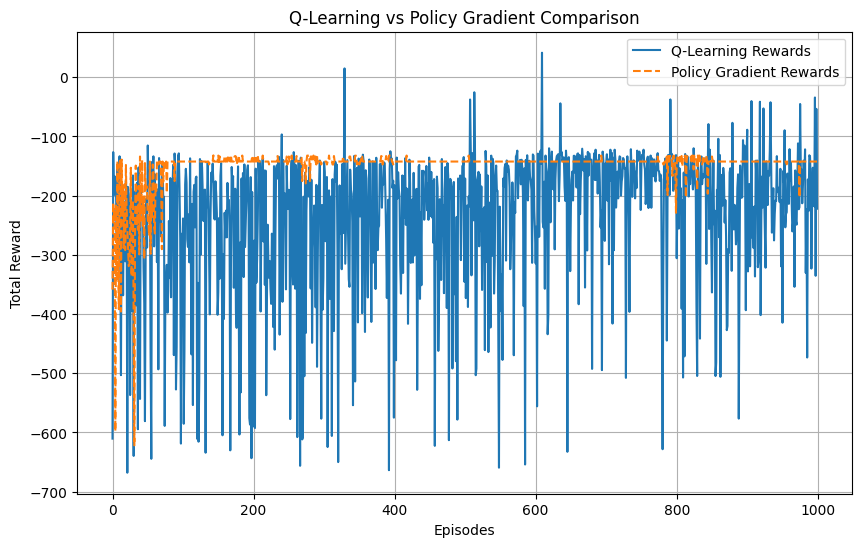

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt

# Q-Learning Implementation
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        total_reward = 0
        done = False
        
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
                
            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(state, action, next_state, done)
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Reward: {total_reward}")
    return q_table, rewards

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Train function
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    policy_rewards = []
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        episode_rewards = []
        episode_log_probs = []
        done = False
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs = policy_net(state_tensor)
            m = torch.distributions.Categorical(action_probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            
            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward_function(state, action.item(), next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + 0.99 * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        loss = sum(-log_prob * reward for log_prob, reward in zip(episode_log_probs, discounted_rewards))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        policy_rewards.append(sum(episode_rewards))  # Collect the total reward of the episode

        if (episode + 1) % 100 == 0:
            print(f"Policy Gradient Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {sum(episode_rewards)}")

    return policy_rewards

# Custom Reward Function
def custom_reward_function(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

# Test function
def test_agent(env, policy_net, num_episodes=10):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        done = False
        total_reward = 0
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()
            
            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(state, action, next_state, done)
            state = next_state
        
        print(f"Test Episode {episode}, Reward: {total_reward}")

# Main execution
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
input_dim = env.observation_space.n  # Number of discrete states
output_dim = env.action_space.n

policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Train Q-Learning agent
q_table, q_rewards = q_learning(env, num_episodes=1000)

# Train Policy Gradient agent and collect its rewards
policy_rewards = train_policy_gradient(env, policy_net, optimizer, num_episodes=1000)

# Test both agents
test_agent(env, policy_net)

# Compare performance and plot
print(f"Q-Learning Average Reward: {np.mean(q_rewards[-100:])}")

# Plot the comparison of rewards between Q-Learning and Policy Gradient
plt.figure(figsize=(10,6))
plt.plot(q_rewards, label="Q-Learning Rewards")
plt.plot(policy_rewards, label="Policy Gradient Rewards", linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning vs Policy Gradient Comparison")
plt.legend()
plt.grid(True)
plt.show()


Q-Learning Episode 0, Reward: -409.0
Q-Learning Episode 100, Reward: -171.0
Q-Learning Episode 200, Reward: -628.0999999999999
Q-Learning Episode 300, Reward: -262.5
Q-Learning Episode 400, Reward: -265.1
Q-Learning Episode 500, Reward: -241.80000000000007
Q-Learning Episode 600, Reward: -138.4
Q-Learning Episode 700, Reward: -178.4
Q-Learning Episode 800, Reward: -139.1
Q-Learning Episode 900, Reward: -155.4
Policy Gradient Episode 100/1000, Loss: -0.3034680485725403, Total Reward: -142.4
Policy Gradient Episode 200/1000, Loss: -1.7409826517105103, Total Reward: -142.4
Policy Gradient Episode 300/1000, Loss: -4.875842571258545, Total Reward: -143.5
Policy Gradient Episode 400/1000, Loss: -1.5655477046966553, Total Reward: -147.8
Policy Gradient Episode 500/1000, Loss: -3.8729488849639893, Total Reward: -138.6
Policy Gradient Episode 600/1000, Loss: -7.518218040466309, Total Reward: -143.5
Policy Gradient Episode 700/1000, Loss: -4.507816314697266, Total Reward: -149.9
Policy Gradient 

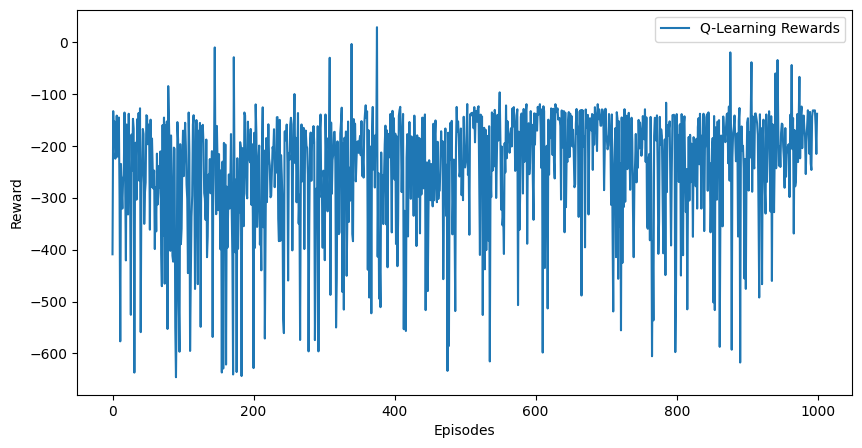

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt

# Configuration for hyperparameters
config = {
    "episodes": 1000,
    "gamma": 0.99,
    "learning_rate": 0.01,
    "epsilon": 0.1,
    "baseline_enabled": True,
    "grad_clip": 0.5
}

# Q-Learning Implementation
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        total_reward = 0
        done = False
        
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
                
            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(state, action, next_state, done)
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Reward: {total_reward}")
    return q_table, rewards

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.value_fc = nn.Linear(128, 1)  # Value function for baseline
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1), self.value_fc(x)

# Train function with baseline for policy gradient
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        episode_rewards = []
        episode_log_probs = []
        episode_values = []
        done = False
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs, value = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()  # Tensor containing the action
            action = action.item()  # Convert to scalar
            
            log_prob = action_dist.log_prob(torch.tensor(action))  # Log prob as tensor
            
            next_state, reward, done, _ = env.step(action)  # Correct usage of action
            reward = custom_reward_function(state, action, next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            episode_values.append(value)
            
            state = next_state
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + config["gamma"] * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        # Advantage estimation using baseline
        if config["baseline_enabled"]:
            value_tensor = torch.tensor(episode_values, dtype=torch.float32)
            advantages = discounted_rewards - value_tensor.squeeze()
        else:
            advantages = discounted_rewards
        
        loss = sum(-log_prob * advantage for log_prob, advantage in zip(episode_log_probs, advantages))

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), config["grad_clip"])
        
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Policy Gradient Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {sum(episode_rewards)}")

# Custom Reward Function
def custom_reward_function(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

# Test function
def test_agent(env, policy_net, num_episodes=10):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        done = False
        total_reward = 0
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs, _ = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()
            
            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(state, action, next_state, done)
            state = next_state
        
        print(f"Test Episode {episode}, Reward: {total_reward}")

# Main execution
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
input_dim = env.observation_space.n  # Number of discrete states
output_dim = env.action_space.n

policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])

# Train Q-Learning and Policy Gradient agents
q_table, q_rewards = q_learning(env, num_episodes=config["episodes"])
train_policy_gradient(env, policy_net, optimizer, num_episodes=config["episodes"])

test_agent(env, policy_net)

# Compare performance
print(f"Q-Learning Average Reward: {np.mean(q_rewards[-100:])}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(q_rewards, label="Q-Learning Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()


Q-Learning Episode 0, Reward: -179.2
Q-Learning Episode 100, Reward: -371.4
Q-Learning Episode 200, Reward: -294.9
Q-Learning Episode 300, Reward: -147.0
Q-Learning Episode 400, Reward: -153.1
Q-Learning Episode 500, Reward: -176.0
Q-Learning Episode 600, Reward: -131.9
Q-Learning Episode 700, Reward: -144.60000000000002
Q-Learning Episode 800, Reward: -190.5
Q-Learning Episode 900, Reward: -313.9000000000001
Policy Gradient Episode 100/1000, Loss: -1.2884907722473145, Total Reward: -143.2
Policy Gradient Episode 200/1000, Loss: -1.0981183052062988, Total Reward: -142.4
Policy Gradient Episode 300/1000, Loss: -1.6796685457229614, Total Reward: -197.6
Policy Gradient Episode 400/1000, Loss: -2.366382598876953, Total Reward: -142.4
Policy Gradient Episode 500/1000, Loss: -3.5686466693878174, Total Reward: -156.7
Policy Gradient Episode 600/1000, Loss: -2.503195285797119, Total Reward: -142.3
Policy Gradient Episode 700/1000, Loss: -2.3727400302886963, Total Reward: -152.1
Policy Gradient

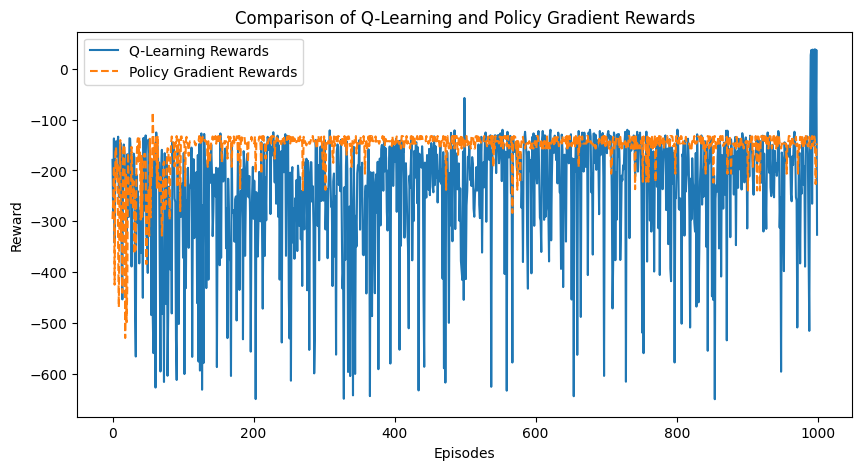

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt

# Configuration for hyperparameters
config = {
    "episodes": 1000,
    "gamma": 0.99,
    "learning_rate": 0.01,
    "epsilon": 0.1,
    "baseline_enabled": True,
    "grad_clip": 0.5
}

# Q-Learning Implementation
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        total_reward = 0
        done = False
        
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
                
            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(state, action, next_state, done)
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Reward: {total_reward}")
    return q_table, rewards

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.value_fc = nn.Linear(128, 1)  # Value function for baseline
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1), self.value_fc(x)

# Train function with baseline for policy gradient
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    rewards = []
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        episode_rewards = []
        episode_log_probs = []
        episode_values = []
        done = False
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs, value = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()  # Tensor containing the action
            action = action.item()  # Convert to scalar
            
            log_prob = action_dist.log_prob(torch.tensor(action))  # Log prob as tensor
            
            next_state, reward, done, _ = env.step(action)  # Correct usage of action
            reward = custom_reward_function(state, action, next_state, done)
            
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            episode_values.append(value)
            
            state = next_state
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + config["gamma"] * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        # Advantage estimation using baseline
        if config["baseline_enabled"]:
            value_tensor = torch.tensor(episode_values, dtype=torch.float32)
            advantages = discounted_rewards - value_tensor.squeeze()
        else:
            advantages = discounted_rewards
        
        loss = sum(-log_prob * advantage for log_prob, advantage in zip(episode_log_probs, advantages))

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), config["grad_clip"])
        
        optimizer.step()

        rewards.append(sum(episode_rewards))  # Store total reward for the episode

        if (episode + 1) % 100 == 0:
            print(f"Policy Gradient Episode {episode+1}/{num_episodes}, Loss: {loss.item()}, Total Reward: {sum(episode_rewards)}")

    return rewards

# Custom Reward Function
def custom_reward_function(state, action, next_state, done):
    goal_state = 63
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

# Test function
def test_agent(env, policy_net, num_episodes=10):
    for episode in range(num_episodes):
        state_info = env.reset(seed=0)
        state = state_info[0] if isinstance(state_info, tuple) else state_info
        done = False
        total_reward = 0
        
        while not done:
            state_tensor = torch.tensor(np.eye(env.observation_space.n)[state], dtype=torch.float32)
            action_probs, _ = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()
            
            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(state, action, next_state, done)
            state = next_state
        
        print(f"Test Episode {episode}, Reward: {total_reward}")

# Main execution
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
input_dim = env.observation_space.n  # Number of discrete states
output_dim = env.action_space.n

policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])

# Train Q-Learning and Policy Gradient agents
q_table, q_rewards = q_learning(env, num_episodes=config["episodes"])
pg_rewards = train_policy_gradient(env, policy_net, optimizer, num_episodes=config["episodes"])

test_agent(env, policy_net)

# Compare performance
print(f"Q-Learning Average Reward: {np.mean(q_rewards[-100:])}")
print(f"Policy Gradient Average Reward: {np.mean(pg_rewards[-100:])}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(q_rewards, label="Q-Learning Rewards")
plt.plot(pg_rewards, label="Policy Gradient Rewards", linestyle="--")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison of Q-Learning and Policy Gradient Rewards")
plt.legend()
plt.show()


Training Q-Learning...
Q-Learning Episode 0, Reward: -140.5, Epsilon: 0.995
Q-Learning Episode 100, Reward: -195.2, Epsilon: 0.603
Early stopping at episode 101

Training Policy Gradient...
Policy Gradient Episode 100, Reward: -240.5999999999998, Loss: 3129.18
Early stopping at episode 118

Testing Q-Learning Agent:
Test Episode 0, Reward: -274.69999999999993
Test Episode 1, Reward: -616.2
Test Episode 2, Reward: -192.90000000000003
Test Episode 3, Reward: -505.0
Test Episode 4, Reward: -135.6
Test Episode 5, Reward: -332.5
Test Episode 6, Reward: -332.59999999999997
Test Episode 7, Reward: -275.0
Test Episode 8, Reward: -142.7
Test Episode 9, Reward: -175.8
Average Test Reward: -298.3

Testing Policy Gradient Agent:
Test Episode 0, Reward: -143.39999999999998
Test Episode 1, Reward: -183.8
Test Episode 2, Reward: -183.69999999999987
Test Episode 3, Reward: -308.80000000000007
Test Episode 4, Reward: -164.0
Test Episode 5, Reward: -165.5
Test Episode 6, Reward: -119.69999999999999
Test

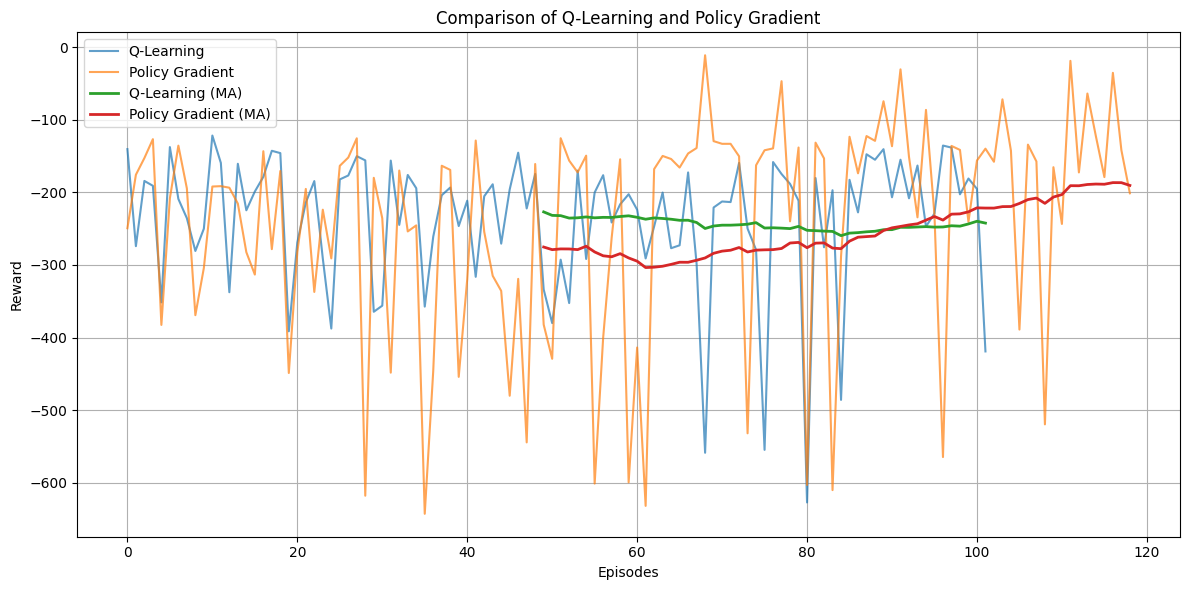

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import warnings
warnings.filterwarnings('ignore')

# Configuration for hyperparameters
config = {
    "episodes": 2000,
    "gamma": 0.99,
    "learning_rate": 0.01,
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay": 0.995,
    "baseline_enabled": True,
    "grad_clip": 0.5,
    "replay_buffer_size": 10000,
    "batch_size": 32,
    "target_update_freq": 100,
    "patience": 50,
    "hidden_size": 128,
    "env_name": "FrozenLake-v1",
    "map_name": "8x8",
    "is_slippery": True
}

# Environment Wrapper that preserves original state and handles Gym API versions
class FrozenLakeWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.original_observation_space = env.observation_space
        self.original_action_space = env.action_space
    
    def reset(self):
        state = super().reset()
        return state[0] if isinstance(state, tuple) else state
    
    def step(self, action):
        result = super().step(action)
        if len(result) == 5:  # New Gym API (v0.26+)
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
            return next_state, reward, done, info
        else:  # Old Gym API
            next_state, reward, done, info = result
            return next_state, reward, done, info

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Policy Network with Value Function
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.shared_layer = nn.Linear(input_dim, hidden_size)
        self.policy_head = nn.Linear(hidden_size, output_dim)
        self.value_head = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.shared_layer(x))
        return torch.softmax(self.policy_head(x), dim=-1), self.value_head(x)

# Q-Learning with Experience Replay and Double Q-Learning
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99):
    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n
    q_table = np.zeros((n_states, n_actions))
    target_q_table = q_table.copy()
    buffer = ReplayBuffer(config["replay_buffer_size"])
    rewards = []
    epsilon = config["epsilon_start"]
    best_reward = -np.inf
    no_improve = 0
    
    writer = SummaryWriter(log_dir='runs/q_learning')
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, done, _ = env.step(action)
            reward = custom_reward_function(env, state, action, next_state, done)
            buffer.push(state, action, reward, next_state, done)
            
            # Sample from replay buffer
            if len(buffer) >= config["batch_size"]:
                batch = buffer.sample(config["batch_size"])
                for s, a, r, ns, d in batch:
                    # Double Q-learning update
                    next_action = np.argmax(q_table[ns])
                    target = r + gamma * target_q_table[ns, next_action] * (1 - d)
                    q_table[s, a] += alpha * (target - q_table[s, a])
            
            state = next_state
            total_reward += reward
        
        # Update target network periodically
        if episode % config["target_update_freq"] == 0:
            target_q_table = q_table.copy()
        
        # Epsilon decay
        epsilon = max(config["epsilon_end"], epsilon * config["epsilon_decay"])
        
        rewards.append(total_reward)
        writer.add_scalar('Reward', total_reward, episode)
        
        # Early stopping
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break
            
        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")
    
    writer.close()
    return q_table, rewards

# Policy Gradient with Advantage Normalization and Learning Rate Scheduling
def train_policy_gradient(env, policy_net, optimizer, num_episodes=1000):
    n_states = env.original_observation_space.n
    rewards = []
    episode_lengths = []
    best_reward = -np.inf
    no_improve = 0
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    writer = SummaryWriter(log_dir='runs/policy_gradient')
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_rewards = []
        episode_log_probs = []
        episode_values = []
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(np.eye(n_states)[state])
            action_probs, value = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            
            next_state, reward, done, _ = env.step(action.item())
            reward = custom_reward_function(env, state, action.item(), next_state, done)
            
            episode_log_probs.append(action_dist.log_prob(action))
            episode_rewards.append(reward)
            episode_values.append(value)
            
            state = next_state
        
        # Calculate discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(episode_rewards):
            cumulative_reward = r + config["gamma"] * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        
        # Calculate advantages with baseline
        values = torch.cat(episode_values).squeeze()
        advantages = discounted_rewards - values.detach()
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Calculate policy loss
        policy_loss = []
        for log_prob, advantage in zip(episode_log_probs, advantages):
            policy_loss.append(-log_prob * advantage)
        policy_loss = torch.stack(policy_loss).sum()
        
        # Calculate value loss
        value_loss = nn.MSELoss()(values, discounted_rewards)
        
        # Total loss
        loss = policy_loss + 0.5 * value_loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), config["grad_clip"])
        optimizer.step()
        
        # Learning rate scheduling
        if episode % 100 == 0:
            scheduler.step()
        
        total_reward = sum(episode_rewards)
        rewards.append(total_reward)
        episode_lengths.append(len(episode_rewards))
        
        writer.add_scalar('Reward', total_reward, episode)
        writer.add_scalar('Loss', loss.item(), episode)
        writer.add_scalar('Episode Length', len(episode_rewards), episode)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], episode)
        
        # Early stopping
        if total_reward > best_reward:
            best_reward = total_reward
            no_improve = 0
            torch.save(policy_net.state_dict(), 'best_policy_model.pth')
        else:
            no_improve += 1
            
        if no_improve >= config["patience"] and episode > 100:
            print(f"Early stopping at episode {episode}")
            break
            
        if (episode + 1) % 100 == 0:
            print(f"Policy Gradient Episode {episode+1}, Reward: {total_reward}, Loss: {loss.item():.2f}")
    
    writer.close()
    return rewards

# Custom Reward Function
def custom_reward_function(env, state, action, next_state, done):
    goal_state = env.original_observation_space.n - 1  # Last state is goal
    hole_penalty = -100
    step_penalty = -0.1
    
    if done:
        if next_state == goal_state:
            return 100  # Reward for reaching the goal
        else:
            return hole_penalty  # Penalty for falling in a hole
    
    distance_to_goal = abs(goal_state - next_state)
    reward = -distance_to_goal * 0.1 + step_penalty
    return reward

# Test function with rendering
def test_agent(env, policy_net=None, q_table=None, num_episodes=10, render=True):
    n_states = env.original_observation_space.n
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if render:
                env.render()
            
            if policy_net is not None:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(np.eye(n_states)[state])
                    action_probs, _ = policy_net(state_tensor)
                    action = torch.argmax(action_probs).item()
            elif q_table is not None:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()
            
            next_state, reward, done, _ = env.step(action)
            total_reward += custom_reward_function(env, state, action, next_state, done)
            state = next_state
        
        rewards.append(total_reward)
        print(f"Test Episode {episode}, Reward: {total_reward}")
    
    avg_reward = np.mean(rewards)
    print(f"Average Test Reward: {avg_reward}")
    return avg_reward

# Main execution
if __name__ == "__main__":
    # Create and wrap environment
    base_env = gym.make(
        config["env_name"],
        is_slippery=config["is_slippery"],
        map_name=config["map_name"]
    )
    env = FrozenLakeWrapper(base_env)
    
    n_states = env.original_observation_space.n
    n_actions = env.original_action_space.n

    # Initialize networks and optimizers
    policy_net = PolicyNetwork(n_states, n_actions, config["hidden_size"])
    optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])

    # Train both agents
    print("Training Q-Learning...")
    q_table, q_rewards = q_learning(env, num_episodes=config["episodes"])
    
    print("\nTraining Policy Gradient...")
    pg_rewards = train_policy_gradient(env, policy_net, optimizer, num_episodes=config["episodes"])

    # Test both agents
    print("\nTesting Q-Learning Agent:")
    q_test_reward = test_agent(env, q_table=q_table, render=False)
    
    print("\nTesting Policy Gradient Agent:")
    policy_net.load_state_dict(torch.load('best_policy_model.pth'))
    pg_test_reward = test_agent(env, policy_net=policy_net, render=False)

    # Compare performance
    print("\nFinal Comparison:")
    print(f"Q-Learning Average Reward (last 100 episodes): {np.mean(q_rewards[-100:]):.2f}")
    print(f"Policy Gradient Average Reward (last 100 episodes): {np.mean(pg_rewards[-100:]):.2f}")
    print(f"Q-Learning Test Reward: {q_test_reward:.2f}")
    print(f"Policy Gradient Test Reward: {pg_test_reward:.2f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(q_rewards, label="Q-Learning", alpha=0.7)
    plt.plot(pg_rewards, label="Policy Gradient", alpha=0.7)
    
    # Add moving averages
    window_size = 50
    q_moving_avg = np.convolve(q_rewards, np.ones(window_size)/window_size, mode='valid')
    pg_moving_avg = np.convolve(pg_rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.plot(range(window_size-1, len(q_rewards)), q_moving_avg, label="Q-Learning (MA)", linewidth=2)
    plt.plot(range(window_size-1, len(pg_rewards)), pg_moving_avg, label="Policy Gradient (MA)", linewidth=2)
    
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Comparison of Q-Learning and Policy Gradient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_comparison.png')
    plt.show()